<a href="https://colab.research.google.com/github/ebi19912/AI/blob/main/DJPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU

In [ ]:
# خواندن فایل داده
df = pd.read_csv('/content/DJCA.csv')

# تبدیل ستون تاریخ به نوع داده تاریخ
df['Date'] = pd.to_datetime(df['observation_date'])

# بررسی و پر کردن مقادیر ناقص
if df.isnull().values.any():
    # پر کردن با میانگین ستون
    for column in df.columns:
      if pd.api.types.is_numeric_dtype(df[column]):
        df[column].fillna(df[column].mean(), inplace=True)

# پر کردن داده‌های روزهای تعطیل با استفاده از forward fill
# فرض می‌کنیم ستون تاریخ به صورت مرتب است
df = df.set_index('Date').resample('D').ffill()

# نمایش اطلاعات اولیه
print(df.head())
print(df.info())

           observation_date     DJCA
Date                                
2015-01-28       2015-01-28  6319.13
2015-01-29       2015-01-29  6389.56
2015-01-30       2015-01-30  6272.52
2015-01-31       2015-01-30  6272.52
2015-02-01       2015-01-30  6272.52
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3653 entries, 2015-01-28 to 2025-01-27
Freq: D
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  3653 non-null   object 
 1   DJCA              3653 non-null   float64
dtypes: float64(1), object(1)
memory usage: 85.6+ KB
None


<ipython-input-2-78effc8f3557>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mean(), inplace=True)


In [ ]:
# انتخاب ستون‌های مورد نظر برای نرمال‌سازی
columns_to_normalize = ['DJCA']

# ایجاد شیء MinMaxScaler
scaler = MinMaxScaler()

# نرمال‌سازی ستون‌های انتخاب‌شده
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# نمایش اطلاعات اولیه پس از نرمال‌سازی
print(df.head())
print(df.info())

           observation_date      DJCA
Date                                 
2015-01-28       2015-01-28  0.095683
2015-01-29       2015-01-29  0.103591
2015-01-30       2015-01-30  0.090450
2015-01-31       2015-01-30  0.090450
2015-02-01       2015-01-30  0.090450
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3653 entries, 2015-01-28 to 2025-01-27
Freq: D
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  3653 non-null   object 
 1   DJCA              3653 non-null   float64
dtypes: float64(1), object(1)
memory usage: 85.6+ KB
None


In [ ]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # طول دنباله‌ها (10 روز گذشته)

# انتخاب ستون قیمت برای ایجاد دنباله‌ها
data = df['DJCA'].values

# ایجاد دنباله‌ها
X, y = create_sequences(data, seq_length)

# چاپ شکل آرایه‌های X و y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (3642, 10)
Shape of y: (3642,)


In [ ]:
# تعریف مدل RNN با LSTM و Dropout
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(Dense(256))
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(Dropout(0.2))
model.add(Dense(8))
model.add(Dropout(0.2))
model.add(Dense(1)) # یک لایه خروجی برای پیش‌بینی قیمت

# کامپایل مدل
model.compile(optimizer='adam', loss='mse') # بهینه‌ساز adam و تابع زیان mse

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# تقسیم داده‌ها به مجموعه‌های آموزش، اعتبارسنجی و تست
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# چاپ شکل مجموعه‌های داده
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (2549, 10)
Shape of y_train: (2549,)
Shape of X_val: (546, 10)
Shape of y_val: (546,)
Shape of X_test: (547, 10)
Shape of y_test: (547,)


In [ ]:
# تغییر شکل داده‌ها برای ورودی مدل LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# آموزش مدل
history = model.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_val, y_val))


Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 238ms/step - loss: 0.1429 - val_loss: 0.0390
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0475 - val_loss: 0.0113
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0346 - val_loss: 0.0030
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0335 - val_loss: 0.0059
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0269 - val_loss: 0.0047
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0253 - val_loss: 0.0047
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0242 - val_loss: 0.0067
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0224 - val_loss: 0.0053
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0211 - val_loss: 0.0043
Epoch 10/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 0.0194 - val_loss: 0.0061
Epoch 11/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0198 - val_loss: 0.0039
Epoch 12/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 

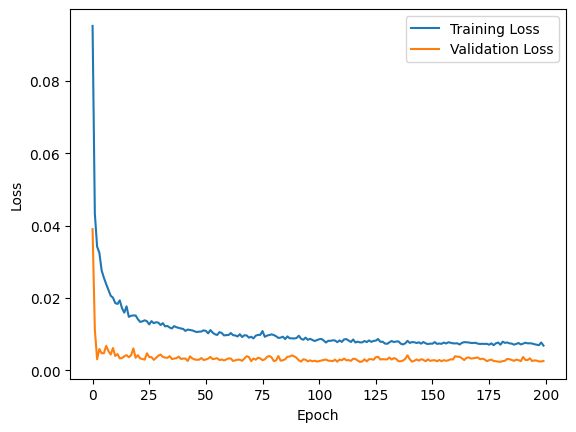

In [ ]:
# تاریخچه آموزش را رسم کنید
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 0.031115744379949944
RMSE: 0.052718578886596


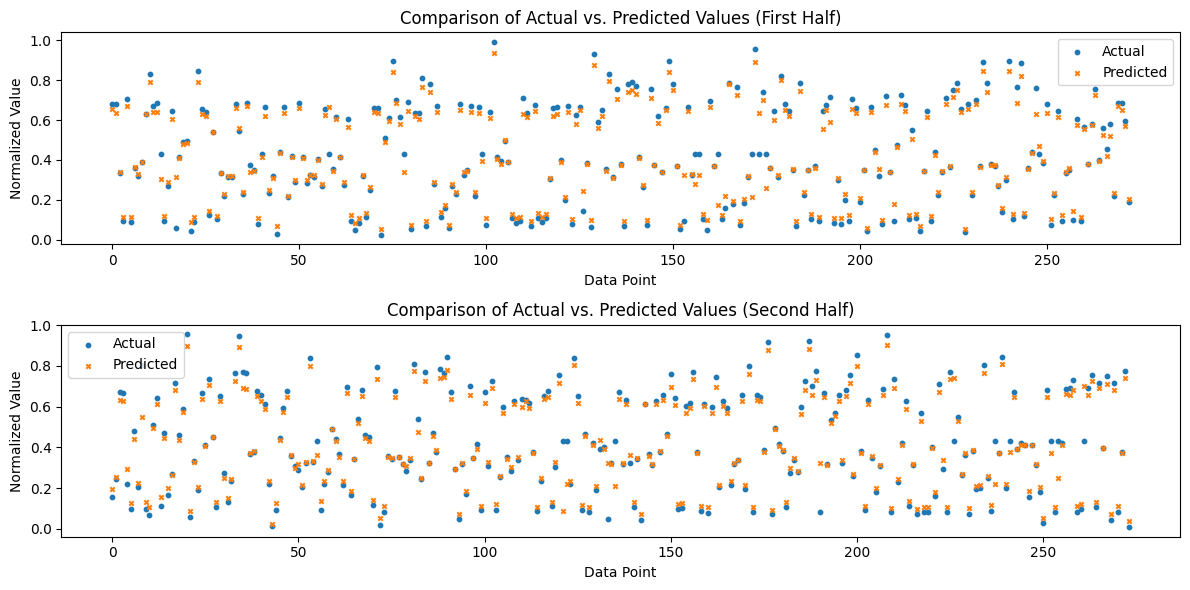

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ارزیابی مدل روی داده‌های تست
y_pred = model.predict(X_test)

# محاسبه MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

# محاسبه RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

# رسم نمودار مقایسه‌ای مقادیر واقعی و پیش‌بینی‌شده
plt.figure(figsize=(12, 6))

# نمودار اول: نیمه اول داده‌ها
plt.subplot(2, 1, 1)
plt.scatter(range(len(y_test[:len(y_test)//2])), y_test[:len(y_test)//2], label='Actual', marker='o', s=10)
plt.scatter(range(len(y_pred[:len(y_test)//2])), y_pred[:len(y_test)//2], label='Predicted', marker='x', s=10)
plt.title('Comparison of Actual vs. Predicted Values (First Half)')
plt.xlabel('Data Point')
plt.ylabel('Normalized Value')
plt.legend()


# نمودار دوم: نیمه دوم داده‌ها
plt.subplot(2, 1, 2)
plt.scatter(range(len(y_test[len(y_test)//2:])), y_test[len(y_test)//2:], label='Actual', marker='o', s=10)
plt.scatter(range(len(y_pred[len(y_test)//2:])), y_pred[len(y_test)//2:], label='Predicted', marker='x', s=10)
plt.title('Comparison of Actual vs. Predicted Values (Second Half)')
plt.xlabel('Data Point')
plt.ylabel('Normalized Value')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# تعریف مدل RNN با GRU و Dropout
model = Sequential()
model.add(GRU(200, activation='relu', input_shape=(seq_length, 1)))  # استفاده از GRU به جای LSTM
model.add(Dropout(0.2))
model.add(Dense(256))
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(Dropout(0.2))
model.add(Dense(8))
model.add(Dropout(0.2))
model.add(Dense(1)) # یک لایه خروجی برای پیش‌بینی قیمت

# کامپایل مدل
model.compile(optimizer='adam', loss='mse') # بهینه‌ساز adam و تابع زیان mse

# بقیه کد بدون تغییر باقی می‌ماند

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# آموزش مدل
history = model.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_val, y_val))


Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 0.1273 - val_loss: 0.0300
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0470 - val_loss: 0.0131
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0390 - val_loss: 0.0033
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0329 - val_loss: 0.0073
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - loss: 0.0301 - val_loss: 0.0086
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.0305 - val_loss: 0.0049
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.0248 - val_loss: 0.0050
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0249 - val_loss: 0.0043
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0222 - val_loss: 0.0046
Epoch 10/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.0227 - val_loss: 0.0037
Epoch 11/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0218 - val_loss: 0.0040
Epoch 12/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1

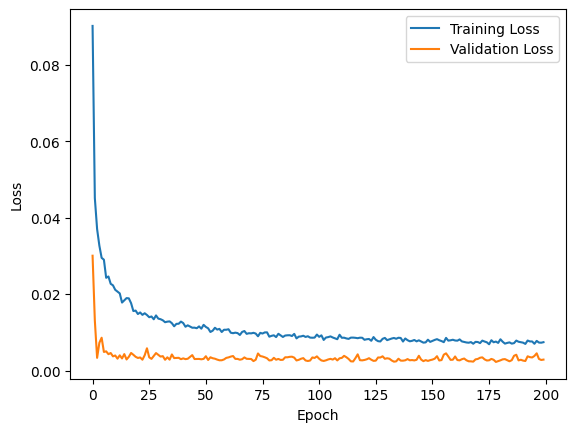

In [ ]:
# تاریخچه آموزش را رسم کنید
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
MAE: 0.03527222203372357
RMSE: 0.054907499896670375


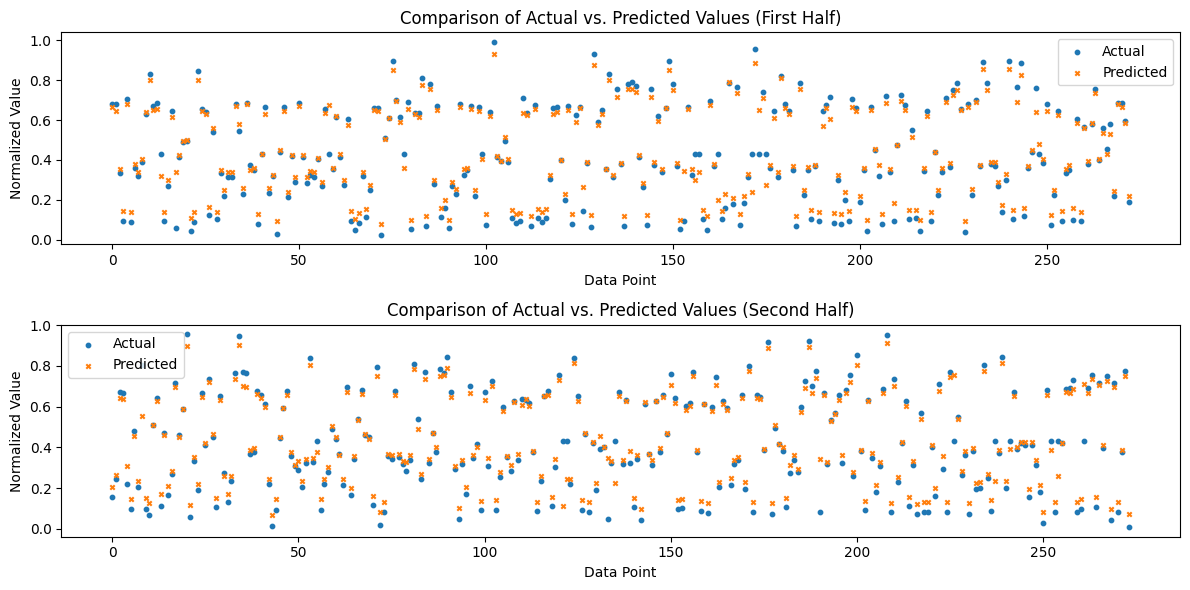

In [ ]:
# ارزیابی مدل روی داده‌های تست
y_pred = model.predict(X_test)

# محاسبه MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

# محاسبه RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

# رسم نمودار مقایسه‌ای مقادیر واقعی و پیش‌بینی‌شده
plt.figure(figsize=(12, 6))

# نمودار اول: نیمه اول داده‌ها
plt.subplot(2, 1, 1)
plt.scatter(range(len(y_test[:len(y_test)//2])), y_test[:len(y_test)//2], label='Actual', marker='o', s=10)
plt.scatter(range(len(y_pred[:len(y_test)//2])), y_pred[:len(y_test)//2], label='Predicted', marker='x', s=10)
plt.title('Comparison of Actual vs. Predicted Values (First Half)')
plt.xlabel('Data Point')
plt.ylabel('Normalized Value')
plt.legend()


# نمودار دوم: نیمه دوم داده‌ها
plt.subplot(2, 1, 2)
plt.scatter(range(len(y_test[len(y_test)//2:])), y_test[len(y_test)//2:], label='Actual', marker='o', s=10)
plt.scatter(range(len(y_pred[len(y_test)//2:])), y_pred[len(y_test)//2:], label='Predicted', marker='x', s=10)
plt.title('Comparison of Actual vs. Predicted Values (Second Half)')
plt.xlabel('Data Point')
plt.ylabel('Normalized Value')
plt.legend()

plt.tight_layout()
plt.show()